In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import pandas as pd
import os
import matplotlib.pyplot as plt

In [4]:
class CarDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, skip_invalid=True):
        self.data = pd.read_csv(csv_file, sep=',', header=None)
        self.root_dir = root_dir
        self.transform = transform
        self.skip_invalid = skip_invalid
        self.valid_indices = []
        
        print("Validating dataset...")
        for idx in tqdm(range(len(self.data))):
            img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0])
            try:
                with Image.open(img_path) as img:
                    img.verify()
                self.valid_indices.append(idx)
            except (IOError, UnidentifiedImageError, OSError) as e:
                if not skip_invalid:
                    raise e
                print(f"Skipping corrupted image {img_path}: {str(e)}")
        
        print(f"Found {len(self.valid_indices)} valid images out of {len(self.data)} total images")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        true_idx = self.valid_indices[idx]
        img_path = os.path.join(self.root_dir, self.data.iloc[true_idx, 0])
        label_str = self.data.iloc[true_idx, 1]
        label = label_to_index[label_str]
        
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            raise

In [3]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs):
    best_acc = 0.0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), 
                          desc=f"Epoch {epoch+1}/{epochs}")

        for batch_idx, (images, labels) in progress_bar:
            try:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                progress_bar.set_postfix(
                    loss=f"{loss.item():.4f}", 
                    acc=f"{100 * correct / total:.2f}%"
                )
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                continue

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        val_acc = evaluate(model, test_loader, device)
        
        print(f'Epoch [{epoch+1}/{epochs}]:')
        print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')
        print(f'Validation Accuracy: {val_acc:.2f}%')
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
            }, 'best_model.pth')
    
    return best_acc

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            try:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            except Exception as e:
                print(f"Error during evaluation: {str(e)}")
                continue
    
    return 100 * correct / total if total > 0 else 0

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_classes = 9
batch_size = 32
epochs = 30
learning_rate = 0.001

data_dir = '/kaggle/input/car-classification-dataset/Public_3/Public_2'
train_csv = '/kaggle/input/car-classification-dataset/train_data.csv'
test_csv = '/kaggle/input/car-classification-dataset/test_data.csv'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
label_to_index = {
    'Honda': 0, 'Mazda': 1, 'Mitsubishi': 2, 'Suzuki': 3,
    'Toyota': 4, 'Hyundai': 5, 'KIA': 6, 'VinFast': 7, 'Others': 8
}

train_dataset = CarDataset(train_csv, data_dir, transform)
test_dataset = CarDataset(test_csv, data_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_accuracy = train_model(model, train_loader, test_loader, criterion, 
                          optimizer, device, epochs)

print(f"\nTraining completed! Best validation accuracy: {best_accuracy:.2f}%")

Using device: cuda
Validating dataset...


  3%|▎         | 855/30252 [00:07<04:25, 110.58it/s]


KeyboardInterrupt: 

In [9]:
class CarClassifier:
    def __init__(self, model_path, device=None):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.model = models.resnet50(weights='IMAGENET1K_V1')  # Load with ImageNet weights
        self.model.fc = nn.Linear(self.model.fc.in_features, 9)  # 9 classes
        
        checkpoint = torch.load(model_path, map_location=self.device)
        if 'model_state_dict' in checkpoint:
            # Load from checkpoint dictionary
            self.model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with accuracy {checkpoint['best_acc']:.2f}%")
        else:
            # Try loading as direct state dict
            self.model.load_state_dict(checkpoint)
            
        self.model = self.model.to(self.device)
        self.model.eval()
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.index_to_label = {
            0: 'Honda', 
            1: 'Mazda', 
            2: 'Mitsubishi', 
            3: 'Suzuki',
            4: 'Toyota', 
            5: 'Hyundai', 
            6: 'KIA', 
            7: 'VinFast', 
            8: 'Others'
        }

    def predict(self, image_path, return_confidence=False):
        try:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)
            
            # Make prediction
            with torch.no_grad():
                outputs = self.model(image_tensor)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                confidence, predicted_idx = torch.max(probabilities, 1)
                predicted_label = self.index_to_label[predicted_idx.item()]
                
                if return_confidence:
                    # Create dictionary of all class probabilities
                    class_probs = {self.index_to_label[i]: prob.item() 
                                 for i, prob in enumerate(probabilities[0])}
                    return predicted_label, confidence.item(), class_probs
                
                return predicted_label
                
        except Exception as e:
            print(f"Error processing image: {str(e)}")
            return None

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]
<ipython-input-9-abfa238845f9>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded 

Loaded checkpoint from epoch 19 with accuracy 74.89%


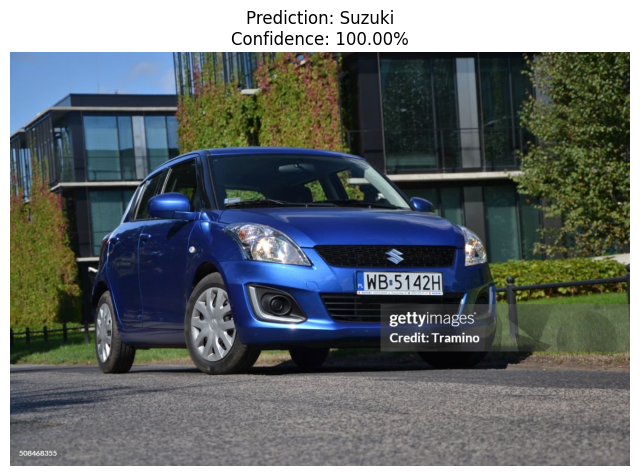


All class probabilities:
Suzuki: 100.00%
Mitsubishi: 0.00%
Honda: 0.00%
Toyota: 0.00%
Others: 0.00%
Mazda: 0.00%
VinFast: 0.00%
Hyundai: 0.00%
KIA: 0.00%


In [10]:
model_path = "/kaggle/input/car-classification-dataset/best_model (4).pth"  # Path to your trained model
classifier = CarClassifier(model_path)

image_path = "/kaggle/input/car-classification-dataset/gettyimages-508468355-1024x1024.jpg"

prediction, confidence, all_probs = classifier.predict(image_path, return_confidence=True)

image = Image.open(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.title(f"Prediction: {prediction}\nConfidence: {confidence*100:.2f}%")
plt.show()

print("\nAll class probabilities:")
for brand, prob in sorted(all_probs.items(), key=lambda x: x[1], reverse=True):
    print(f"{brand}: {prob*100:.2f}%")

Validating dataset...


 57%|█████▋    | 4301/7564 [00:05<00:04, 800.99it/s]

Skipping corrupted image /kaggle/input/car-classification-dataset/Public_3/Public_2/Others/22520477-22520490.Others.8.jpg: cannot identify image file '/kaggle/input/car-classification-dataset/Public_3/Public_2/Others/22520477-22520490.Others.8.jpg'
Skipping corrupted image /kaggle/input/car-classification-dataset/Public_3/Public_2/Others/22520477-22520490.Others.30.jpg: cannot identify image file '/kaggle/input/car-classification-dataset/Public_3/Public_2/Others/22520477-22520490.Others.30.jpg'
Skipping corrupted image /kaggle/input/car-classification-dataset/Public_3/Public_2/Others/22520477-22520490.Others.6.jpg: cannot identify image file '/kaggle/input/car-classification-dataset/Public_3/Public_2/Others/22520477-22520490.Others.6.jpg'
Skipping corrupted image /kaggle/input/car-classification-dataset/Public_3/Public_2/Others/22520477-22520490.Others.4.jpg: cannot identify image file '/kaggle/input/car-classification-dataset/Public_3/Public_2/Others/22520477-22520490.Others.4.jpg'


 94%|█████████▎| 7074/7564 [00:08<00:00, 927.88it/s]

Skipping corrupted image /kaggle/input/car-classification-dataset/Public_3/Public_2/VinFast/22521692-22521676.VinFast.96.jpg: cannot identify image file '/kaggle/input/car-classification-dataset/Public_3/Public_2/VinFast/22521692-22521676.VinFast.96.jpg'


100%|██████████| 7564/7564 [00:09<00:00, 814.48it/s]


Found 7559 valid images out of 7564 total images


Evaluating model:  15%|█▍        | 35/237 [00:19<01:41,  2.00it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating model: 100%|██████████| 237/237 [02:23<00:00,  1.65it/s]


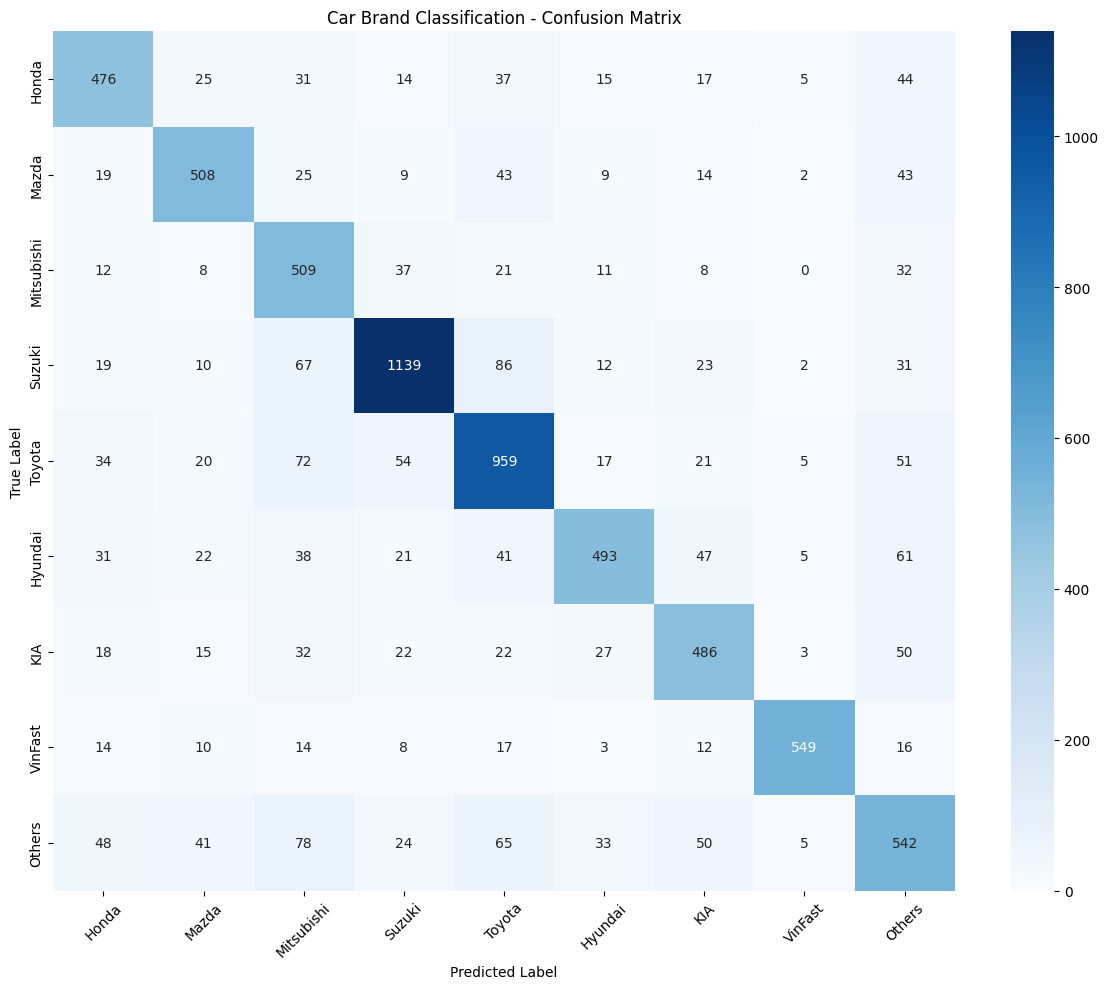


Classification Report:
              precision    recall  f1-score   support

       Honda      0.709     0.717     0.713       664
       Mazda      0.771     0.756     0.763       672
  Mitsubishi      0.588     0.798     0.677       638
      Suzuki      0.858     0.820     0.838      1389
      Toyota      0.743     0.778     0.760      1233
     Hyundai      0.795     0.650     0.715       759
         KIA      0.717     0.720     0.718       675
     VinFast      0.953     0.854     0.901       643
      Others      0.623     0.612     0.617       886

    accuracy                          0.749      7559
   macro avg      0.751     0.745     0.745      7559
weighted avg      0.757     0.749     0.751      7559


Per-class Accuracy:
Honda: 71.69%
Mazda: 75.60%
Mitsubishi: 79.78%
Suzuki: 82.00%
Toyota: 77.78%
Hyundai: 64.95%
KIA: 72.00%
VinFast: 85.38%
Others: 61.17%


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create test dataset and loader (if not already created)
data_dir = '/kaggle/input/car-classification-dataset/Public_3/Public_2'
test_csv = '/kaggle/input/car-classification-dataset/test_data.csv'
test_dataset = CarDataset(test_csv, data_dir, classifier.transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluation
classifier.model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating model"):
        images = images.to(classifier.device)
        labels = labels.to(classifier.device)
        
        outputs = classifier.model(images)
        _, predictions = torch.max(outputs, 1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
class_names = list(classifier.index_to_label.values())
report = classification_report(all_labels, all_predictions, 
                             target_names=class_names,
                             digits=3)

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Car Brand Classification - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(report)

# Calculate and print per-class accuracy
per_class_accuracy = {}
for i, class_name in enumerate(class_names):
    class_mask = np.array(all_labels) == i
    if np.sum(class_mask) > 0:
        class_correct = np.sum((np.array(all_predictions) == i) & class_mask)
        class_total = np.sum(class_mask)
        per_class_accuracy[class_name] = class_correct / class_total

print("\nPer-class Accuracy:")
for class_name, acc in per_class_accuracy.items():
    print(f"{class_name}: {acc*100:.2f}%")